In [4]:
#add environment to PYTHONPATH
import sys
import os
env_path = os.path.join(os.path.abspath(os.getcwd()), '..\\Environments\\ContinuousCartPole')
sys.path.append(env_path)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical, Normal
from continuous_cartpole import ContinuousCartPoleEnv

import gym
from tqdm import tqdm_notebook
import numpy as np
from collections import deque

In [5]:
#discount factor for future utilities
DISCOUNT_FACTOR = 0.99

#number of episodes to run
NUM_EPISODES = 1000

#max steps per episode
MAX_STEPS = 500

#score agent needs for environment to be solved
SOLVED_SCORE = 195

#device to run model on 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
#Using a neural network to learn our policy parameters for one continuous action
class PolicyNetwork(nn.Module):
    
    #Takes in observations and outputs actions mu and sigma
    def __init__(self, observation_space):
        super(PolicyNetwork, self).__init__()
        self.input_layer = nn.Linear(observation_space, 128)
        self.output_layer = nn.Linear(128, 2)
    
    #forward pass
    def forward(self, x):
        #input states
        x = self.input_layer(x)
        
        x = F.relu(x)
        
        #actions
        action_parameters = self.output_layer(x)
        
        return action_parameters

In [7]:
#Using a neural network to learn state value
class StateValueNetwork(nn.Module):
    
    #Takes in state
    def __init__(self, observation_space):
        super(StateValueNetwork, self).__init__()
        
        self.input_layer = nn.Linear(observation_space, 128)
        self.output_layer = nn.Linear(128, 1)
        
    def forward(self, x):
        #input layer
        x = self.input_layer(x)
        
        #activiation relu
        x = F.relu(x)
        
        #get state value
        state_value = self.output_layer(x)
        
        return state_value

In [8]:
def select_action(network, state):
    ''' Selects an action given state
    Args:
    - network (Pytorch Model): neural network used in forward pass
    - state (Array): environment state
    
    Return:
    - action.item() (float): continuous action
    - log_action (float): log of probability density of action
    
    '''
    
    #create state tensor
    state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)
    state_tensor.required_grad = True
    
    #forward pass through network
    action_parameters = network(state_tensor)
    
    #get mean and std, get normal distribution
    mu, sigma = action_parameters[:, :1], torch.exp(action_parameters[:, 1:])
    m = Normal(mu[:, 0], sigma[:, 0])

    #sample action, get log probability
    action = m.sample()
    log_action = m.log_prob(action)

    return action.item(), log_action, mu[:, 0].item(), sigma[:, 0].item()

In [18]:
#Make environment
env = ContinuousCartPoleEnv()

#Init network
policy_network = PolicyNetwork(env.observation_space.shape[0]).to(DEVICE)
stateval_network = StateValueNetwork(env.observation_space.shape[0]).to(DEVICE)

#Init optimizer
policy_optimizer = optim.Adam(policy_network.parameters(), lr=0.001)
stateval_optimizer = optim.Adam(stateval_network.parameters(), lr=0.001)

C:\Users\cheng\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [19]:
#track scores
scores = []

#track distribution parameters
means = []
stds = []

#track recent scores
recent_scores = deque(maxlen = 100)

#run episodes
for episode in tqdm_notebook(range(NUM_EPISODES)):
    
    #init variables
    state = env.reset()
    done = False
    score = 0
    I = 1
    
    #run episode, update online
    for step in range(MAX_STEPS):
        
        #get action and log probability
        action, la, mu, sigma = select_action(policy_network, state)
        
        #action = min(max(1, action), -1)
        
        means.append(mu)
        stds.append(sigma)
        
        #step with action
        new_state, reward, done, _ = env.step(action)
        
        #update episode score
        score += reward
        
        #get state value of current state
        state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)
        state_val = stateval_network(state_tensor)
        
        #get state value of next state
        new_state_tensor = torch.from_numpy(new_state).float().unsqueeze(0).to(DEVICE)        
        new_state_val = stateval_network(new_state_tensor)
        
        #if terminal state, next state val is 0
        if done:
            new_state_val = torch.tensor([0]).float().unsqueeze(0).to(DEVICE)
        
        #calculate value function loss with MSE
        val_loss = F.mse_loss(reward + DISCOUNT_FACTOR * new_state_val, state_val)
        val_loss *= I
        
        #calculate policy loss
        advantage = reward + DISCOUNT_FACTOR * new_state_val.item() - state_val.item()
        policy_loss = -la * advantage
        policy_loss *= I
        
        #Backpropagate policy
        policy_optimizer.zero_grad()
        policy_loss.backward(retain_graph=True)
        policy_optimizer.step()
        
        #Backpropagate value
        stateval_optimizer.zero_grad()
        val_loss.backward()
        stateval_optimizer.step()
        
        if done:
            break
            
        #move into new state, discount I
        state = new_state
        I *= DISCOUNT_FACTOR
    
    #append episode score 
    scores.append(score)
    recent_scores.append(score)
    
    #early stopping if we meet solved score goal
    if np.array(recent_scores).mean() >= SOLVED_SCORE and len(recent_scores) >= 100:
        break
        
        

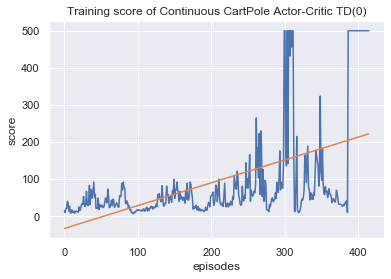

In [20]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np

sns.set()

plt.plot(scores)
plt.ylabel('score')
plt.xlabel('episodes')
plt.title('Training score of Continuous CartPole Actor-Critic TD(0)')
#plt.axis((None,None,0,2))

reg = LinearRegression().fit(np.arange(len(scores)).reshape(-1, 1), np.array(scores).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(scores)).reshape(-1, 1))
plt.plot(y_pred)
plt.show()

In [21]:
np.argwhere(np.isnan(means))


array([[24697],
       [24698],
       [24699],
       ...,
       [39194],
       [39195],
       [39196]], dtype=int64)

In [14]:
done = False
state = env.reset()
scores = []

for _ in tqdm_notebook(range(50)):
    state = env.reset()
    done = False
    score = 0
    for step in range(MAX_STEPS):
        env.render()
        action, lp, mu, sigma = select_action(policy_network, state)
        action = min(max(1, action), -1)

        new_state, reward, done, info = env.step(action)
        score += reward
        state = new_state
        
        if done:
            break
    scores.append(score)
env.close()

In [15]:
np.array(scores).mean()

5.76

In [34]:
env.close()